# Project 2: Data Representations and Clustering

## Group Members
- Shaira Alam

- Vani Agrawal 

- Dhakshina Ilango

## Package Installation

In [2]:
! pip install numpy
! pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
! pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import TruncatedSVD, NMF
import numpy as np
import plotmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
import numpy as np 
from plotmat import plot_mat
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import umap.umap_ as umap

# Part 1 - Clustering on Text Data

## Question 1

### 1.1 Report the dimensions of the TF-IDF matrix you obtain.

In [25]:

# Categories for Class 1 and 2
comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

# Loads the dataset
newsgroups_data = fetch_20newsgroups(subset='all', categories=comp_categories+rec_categories, shuffle=True, remove=('headers', 'footers'), random_state=42)

In [26]:
# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(min_df=3, stop_words='english')
X_train_tfidf = tfidf_vect.fit_transform(newsgroups_data.data)

# Dimensions of the TD-IDF matrix
tfidf_dims = X_train_tfidf.shape

print("Dimensions of the TD-IDF matrix: ",tfidf_dims)

Dimensions of the TD-IDF matrix:  (7882, 23522)


## Question 2

### 2.1 Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix.

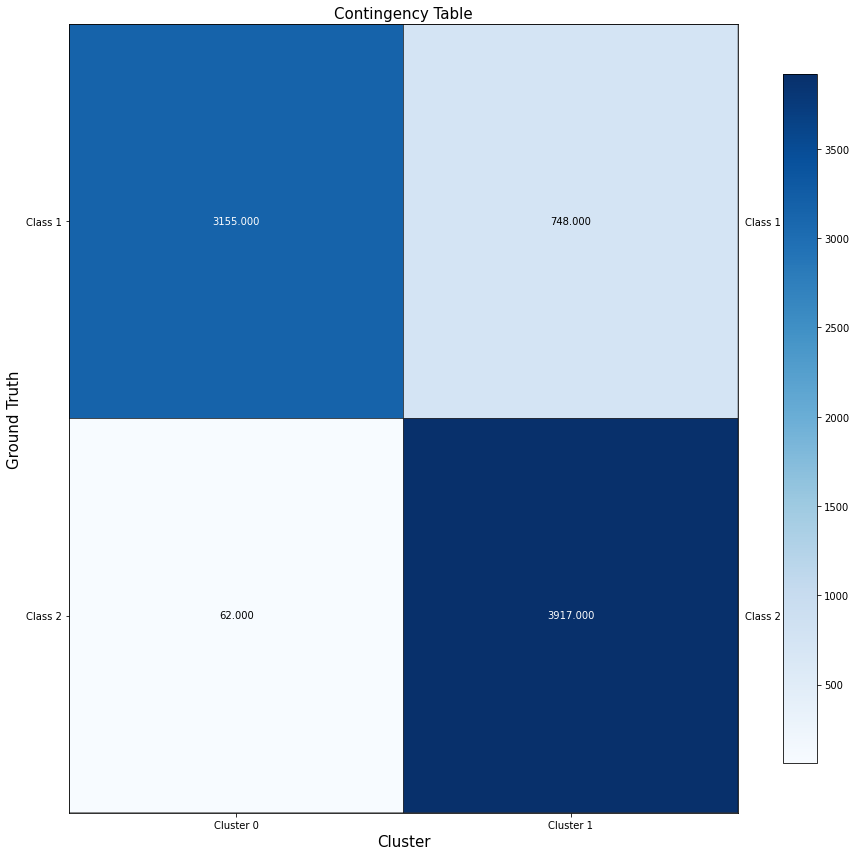

In [37]:
# K-means clustering with k = 2 using the TF-IDF data
k = 2
km = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=30)
clusters = km.fit_predict(X_train_tfidf)

# Ground truth labels
ground_truth = [int(i/4) for i in newsgroups_data.target]

mat = contingency_matrix(ground_truth, clusters)

# Visualizing the matrix using plotmat.py
xlabels = ['Cluster 0', 'Cluster 1']
ylabels = ['Class 1', 'Class 2']
plotmat.plot_mat(mat, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(12,12), title="Contingency Table")


### 2.2 Does the contingency matrix have to be square-shaped?

No, the contingency matrix does not have to be square shaped since the contingency matrix is a matrix where the rows represent the ground truth labels and the columns represent the predicted cluster labels, so therefore the contingency matrix can be rectangular shaped as well. However, in this scenario, since we only had 2 clusters and 2 ground truth labels, the contingency matrix was square-shaped.

## Question 3

### 3.1 Report the 5 clustering measures explained in the introduction for K-means clustering.

### 1. Homogeneity 
- is a measure of how “pure” the clusters are. If each cluster contains only data points from a single class, the homogeneity is satisfied.

In [33]:
h_score= homogeneity_score(ground_truth,clusters)
print("Homogeneity Score:", h_score)

Homogeneity Score: 0.568013245785168


### 2. Completeness 
- indicates how much of the data points of a class are assigned to the same cluster.

In [7]:
c_score = completeness_score(ground_truth,clusters)
print("Completeness:", c_score)

Completeness: 0.5822303423168675


### 3. V-measure
- is the harmonic average of homogeneity score and completeness score.

In [8]:
v_score = v_measure_score(ground_truth,clusters)
print("V-measure:", v_score)

V-measure: 0.5750339318643112


### 4. Adjusted Rand Index 
- is similar to accuracy, which computes similarity between the clustering labels and ground truth labels. This method counts all pairs of points that both fall either in the same cluster and the same class or in different clusters and different classes.

In [9]:
adj_ri = adjusted_rand_score(ground_truth,clusters)
print("Adjusted Rand Index:", adj_ri)

Adjusted Rand Index: 0.631133674855338


### 5. Adjusted Mutual Information Score 
- measures the mutual information between the cluster label distribution and the ground truth label distributions.

In [10]:
adj_mi = adjusted_mutual_info_score(ground_truth,clusters)
print("Adjusted Mutual Information Score:", adj_mi)

Adjusted Mutual Information Score: 0.5749945448304503


## Question 4

### 4.1 Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.

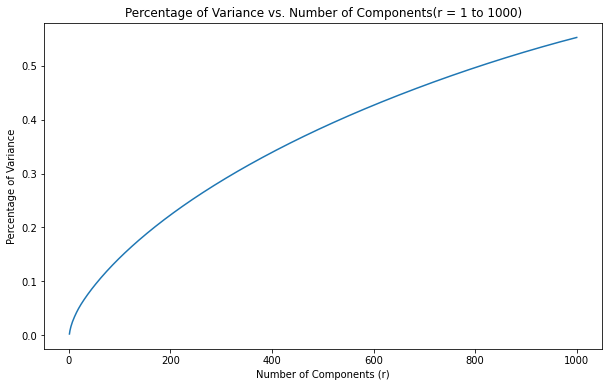

In [11]:
# Truncated SVD
r = 1000
svd = TruncatedSVD(n_components=r, random_state=0)
svd.fit_transform(X_train_tfidf)

# Cumulative explained variance ratio for each component
explained_variance = svd.explained_variance_ratio_.cumsum()

# R components
X_vals = np.array(range(1, r+1))

# Plot of the percentage of variance vs number of components
plt.figure(figsize=(10,6))
plt.plot(X_vals, explained_variance)
plt.title("Percentage of Variance vs. Number of Components(r = 1 to 1000)")
plt.xlabel("Number of Components (r)")
plt.ylabel("Percentage of Variance")
plt.show()

## Question 5

### 5.1 Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1 − 10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD and NMF.

In [12]:
r_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Metric scores for SVD
svd_h_score, svd_c_score, svd_v_score, svd_ajd_ri, svd_adj_mi = [], [], [], [], []

# Loops over the r values
for r in r_vals:
    # SVD
    svd = TruncatedSVD(n_components=r, random_state=0)
    X_train_svd = svd.fit_transform(X_train_tfidf)

    # K-Means
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    svd_cluster = km.fit_predict(X_train_svd)

    # Clusters metric scores for SVD
    svd_h_score.append(homogeneity_score(ground_truth, svd_cluster))
    svd_c_score.append(completeness_score(ground_truth, svd_cluster))
    svd_v_score.append(v_measure_score(ground_truth, svd_cluster))
    svd_ajd_ri.append(adjusted_rand_score(ground_truth, svd_cluster))
    svd_adj_mi.append(adjusted_mutual_info_score(ground_truth, svd_cluster))

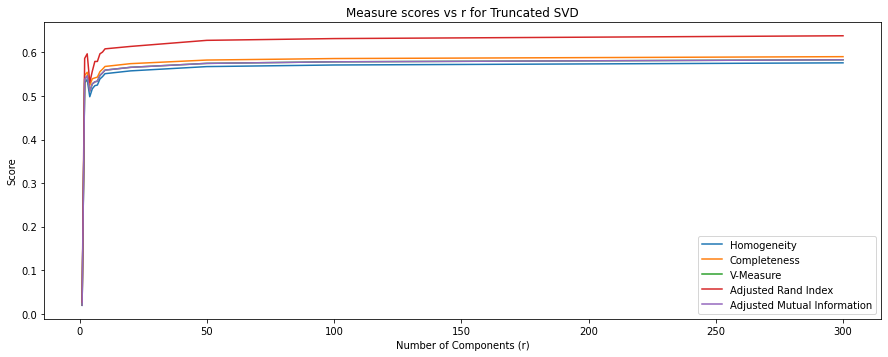

In [13]:
# Truncated SVD Plot
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals, svd_h_score, label='Homogeneity')
plt.plot(r_vals, svd_c_score, label='Completeness')
plt.plot(r_vals, svd_v_score, label='V-Measure')
plt.plot(r_vals, svd_ajd_ri, label='Adjusted Rand Index')
plt.plot(r_vals, svd_adj_mi, label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r for Truncated SVD")
plt.legend()

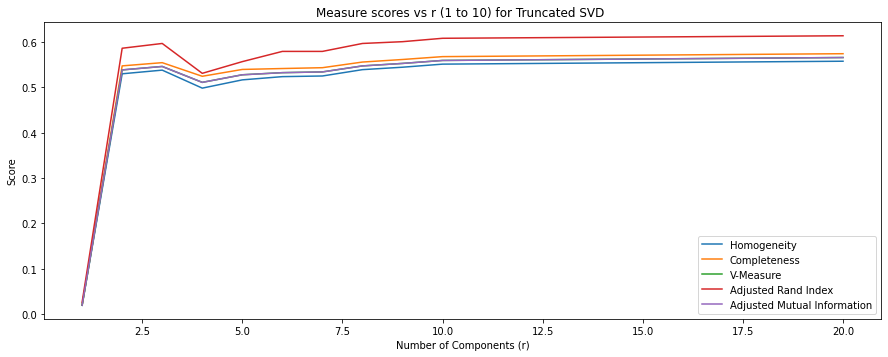

In [18]:
# Zoomed Truncated SVD plot (r = 1 to 20)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals[:11], svd_h_score[:11], label='Homogeneity')
plt.plot(r_vals[:11], svd_c_score[:11], label='Completeness')
plt.plot(r_vals[:11], svd_v_score[:11], label='V-Measure')
plt.plot(r_vals[:11], svd_ajd_ri[:11], label='Adjusted Rand Index')
plt.plot(r_vals[:11], svd_adj_mi[:11], label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r (1 to 20) for Truncated SVD ")
plt.legend()

In [15]:
r_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Metric scores for NMF
nmf_h_score, nmf_c_score, nmf_v_score, nmf_ajd_ri, nmf_adj_mi = [], [], [], [], []

# Loops over the r values
for r in r_vals:
    # NMF
    nmf = NMF(n_components=r, random_state=0, max_iter=2000)
    X_train_nmf = nmf.fit_transform(X_train_tfidf)

    # K-means
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    nmf_cluster = km.fit_predict(X_train_nmf)

    # Clusters metric scores for NMF
    nmf_h_score.append(homogeneity_score(ground_truth, nmf_cluster))
    nmf_c_score.append(completeness_score(ground_truth, nmf_cluster))
    nmf_v_score.append(v_measure_score(ground_truth, nmf_cluster))
    nmf_ajd_ri.append(adjusted_rand_score(ground_truth, nmf_cluster))
    nmf_adj_mi.append(adjusted_mutual_info_score(ground_truth, nmf_cluster))

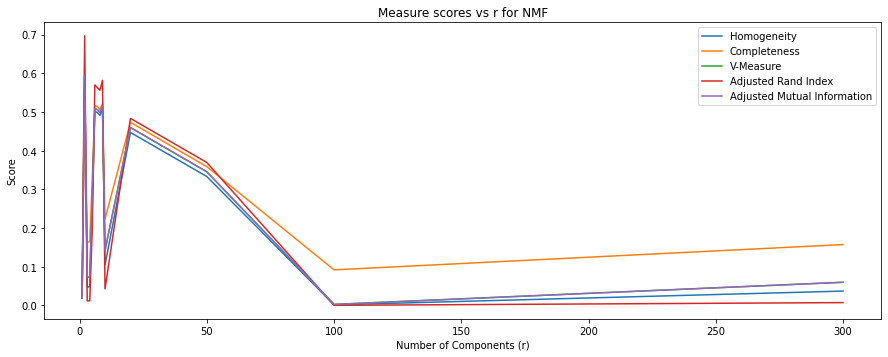

In [16]:
# NMF Plot
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals, nmf_h_score, label='Homogeneity')
plt.plot(r_vals, nmf_c_score, label='Completeness')
plt.plot(r_vals, nmf_v_score, label='V-Measure')
plt.plot(r_vals, nmf_ajd_ri, label='Adjusted Rand Index')
plt.plot(r_vals, nmf_adj_mi, label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r for NMF")
plt.legend()

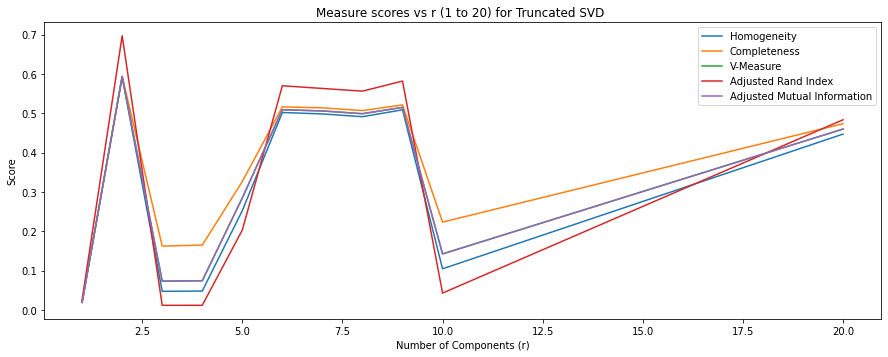

In [19]:
# Zoomed NMF plot (r = 1 to 20)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals[:11], nmf_h_score[:11], label='Homogeneity')
plt.plot(r_vals[:11], nmf_c_score[:11], label='Completeness')
plt.plot(r_vals[:11], nmf_v_score[:11], label='V-Measure')
plt.plot(r_vals[:11], nmf_ajd_ri[:11], label='Adjusted Rand Index')
plt.plot(r_vals[:11], nmf_adj_mi[:11], label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r (1 to 20) for Truncated SVD ")
plt.legend()

### 5.2 Report a good choice of r for SVD and NMF respectively.

According to the graphs, the best rank for SVD is 20 and the best rank for NMF is 2.

## Question 6

### 6.1 How do you explain the non-monotonic behavior of the measures as r increases?

*incomplete*

## Question 7

### 7.1 Are these measures on average better than those computed in Question 3?

*incomplete*

## Question 8

### 8.1 Visualize the clustering results for SVD with your optimal choice of r for K-Means clustering

Text(0.5, 1.0, 'Ground Truth K-Means clustering (SVD)')

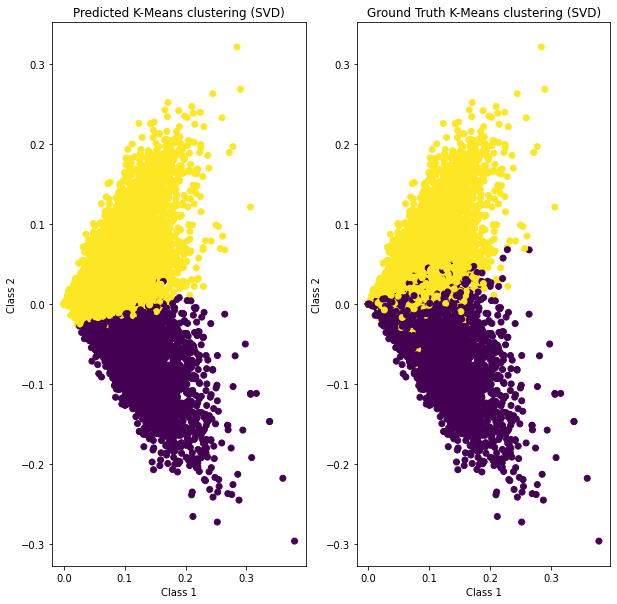

In [55]:
# Optimal choice of r
opt_r_svd = 20

# SVD
svd = TruncatedSVD(n_components=opt_r_svd, random_state=0)
X_train_svd = svd.fit_transform(X_train_tfidf)

# K-Means
km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
svd_cluster = km.fit_predict(X_train_svd)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=svd_cluster, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Predicted K-Means clustering (SVD)')

plt.subplot(122)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=ground_truth, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Ground Truth K-Means clustering (SVD)')

### 8.2 Visualize the clustering results for NMF with your choice of r for K-Means clustering.

Text(0.5, 1.0, 'Ground Truth K-Means clustering (NMF)')

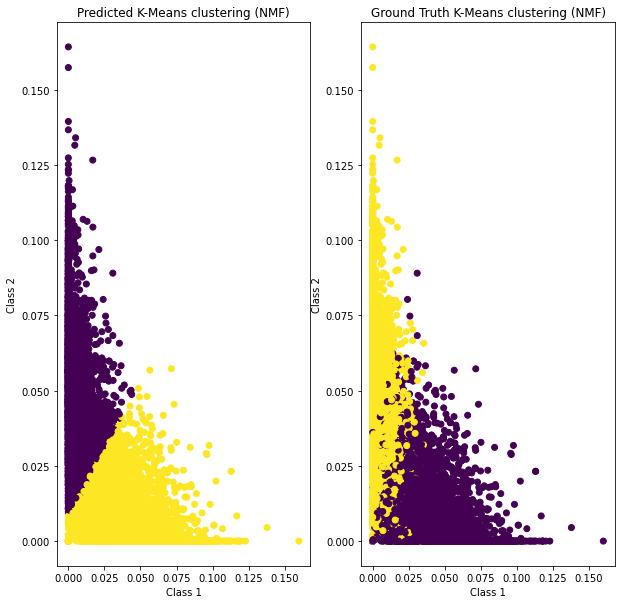

In [56]:
# Optimal choice of r
opt_r_nmf = 2

# NMF
nmf = NMF(n_components=opt_r_nmf, random_state=0, max_iter=2000)
X_train_nmf = nmf.fit_transform(X_train_tfidf)

# K-means
km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
nmf_cluster = km.fit_predict(X_train_nmf)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.scatter(X_train_nmf[:, 0], X_train_nmf[:, 1], c=nmf_cluster, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Predicted K-Means clustering (NMF)')

plt.subplot(122)
plt.scatter(X_train_nmf[:, 0], X_train_nmf[:, 1], c=ground_truth, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Ground Truth K-Means clustering (NMF)')

## Question 9

### 9.1 What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?

#### QUESTION 10: Load documents with the same configuration as in Question 1, but for ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality using BOTH NMF and SVD (specify settings you choose and why), and perform K-Means clustering with k=20 . Visualize the contingency matrix and report the five clustering metrics (DO BOTH NMF AND SVD).

- The dimensions of the TF-IDF matrix is (18846, 45365)
- From Q5 we got optimal value of r as 2 for NMF and 300 for SVD therefore these values of r will be used for NMF and SVD respectively 

In [8]:
# Load the dataset
newsgroups_data20 = fetch_20newsgroups(subset='all', shuffle=True, remove=('headers', 'footers'), random_state=42)

In [9]:
# TF-IDF Vectorizer
tfidf_vect20 = TfidfVectorizer(min_df=3, stop_words='english')
X_train_tfidf20 = tfidf_vect20.fit_transform(newsgroups_data20.data)

print("Dimensions of the TD-IDF matrix: ", X_train_tfidf20.shape)

Dimensions of the TD-IDF matrix:  (18846, 45365)


### NMF

In [9]:
# NMF
nmf20 = NMF(n_components=2, random_state=0, max_iter=2000)
X_train_nmf20 = nmf20.fit_transform(X_train_tfidf20)

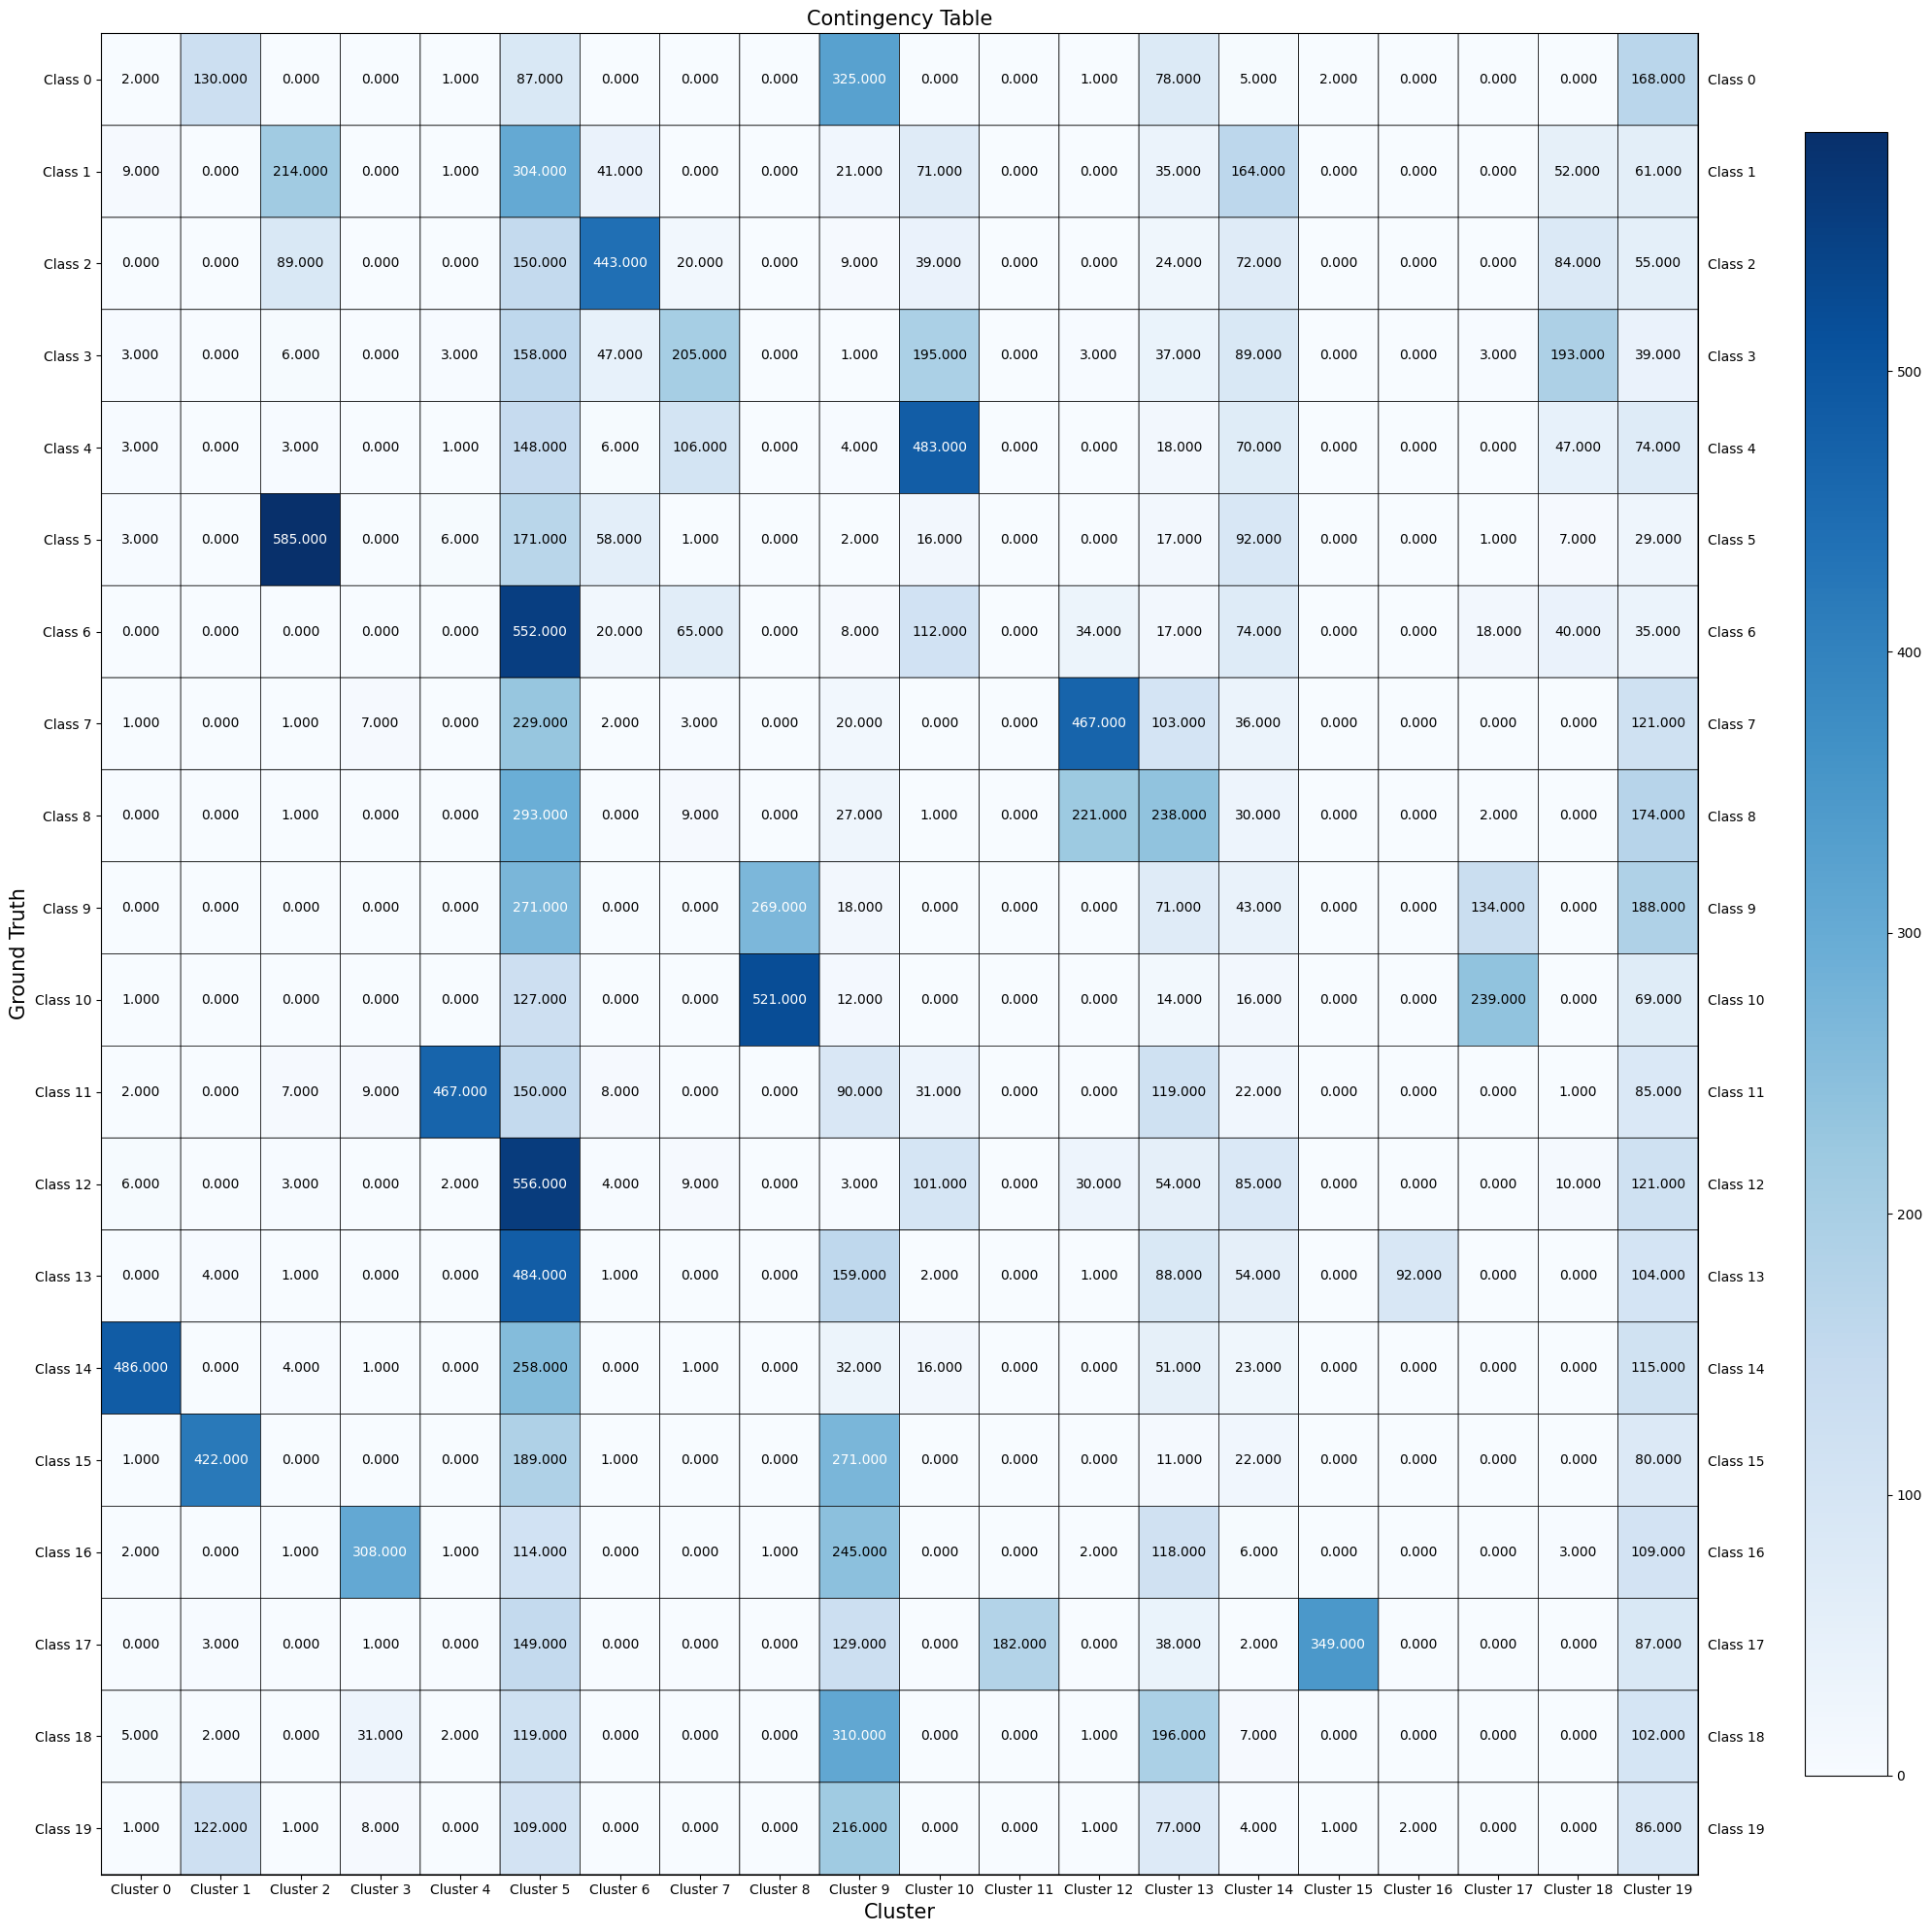

In [13]:

km_nmf20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
clusters_nmf20 = km_nmf20.fit_predict(X_train_tfidf20)

# Ground truth labels
ground_truth = newsgroups_data20.target

mat_nmf20 = contingency_matrix(ground_truth, clusters_nmf20)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,20)]
ylabels = [f'Class {i}'.format(i) for i in range(0,20)]
plotmat.plot_mat(mat_nmf20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

In [15]:
print("Homogeneity Score:", homogeneity_score(ground_truth, clusters_nmf20))
print("Completeness:", completeness_score(ground_truth,clusters_nmf20))
print("V-measure:", v_measure_score(ground_truth,clusters_nmf20))
print("Adjusted RI", adjusted_rand_score(ground_truth, clusters_nmf20))
print("Adjusted MI", adjusted_mutual_info_score(ground_truth, clusters_nmf20))

Homogeneity Score: 0.3482673118916205
Completeness: 0.39700467835958114
V-measure: 0.3710423951236527
Adjusted RI 0.12210456974890385
Adjusted MI 0.3688686184350024


### SVD

In [17]:
# SVD
svd20 = TruncatedSVD(n_components=300, random_state=0)
X_train_svd20 = svd20.fit_transform(X_train_tfidf20)

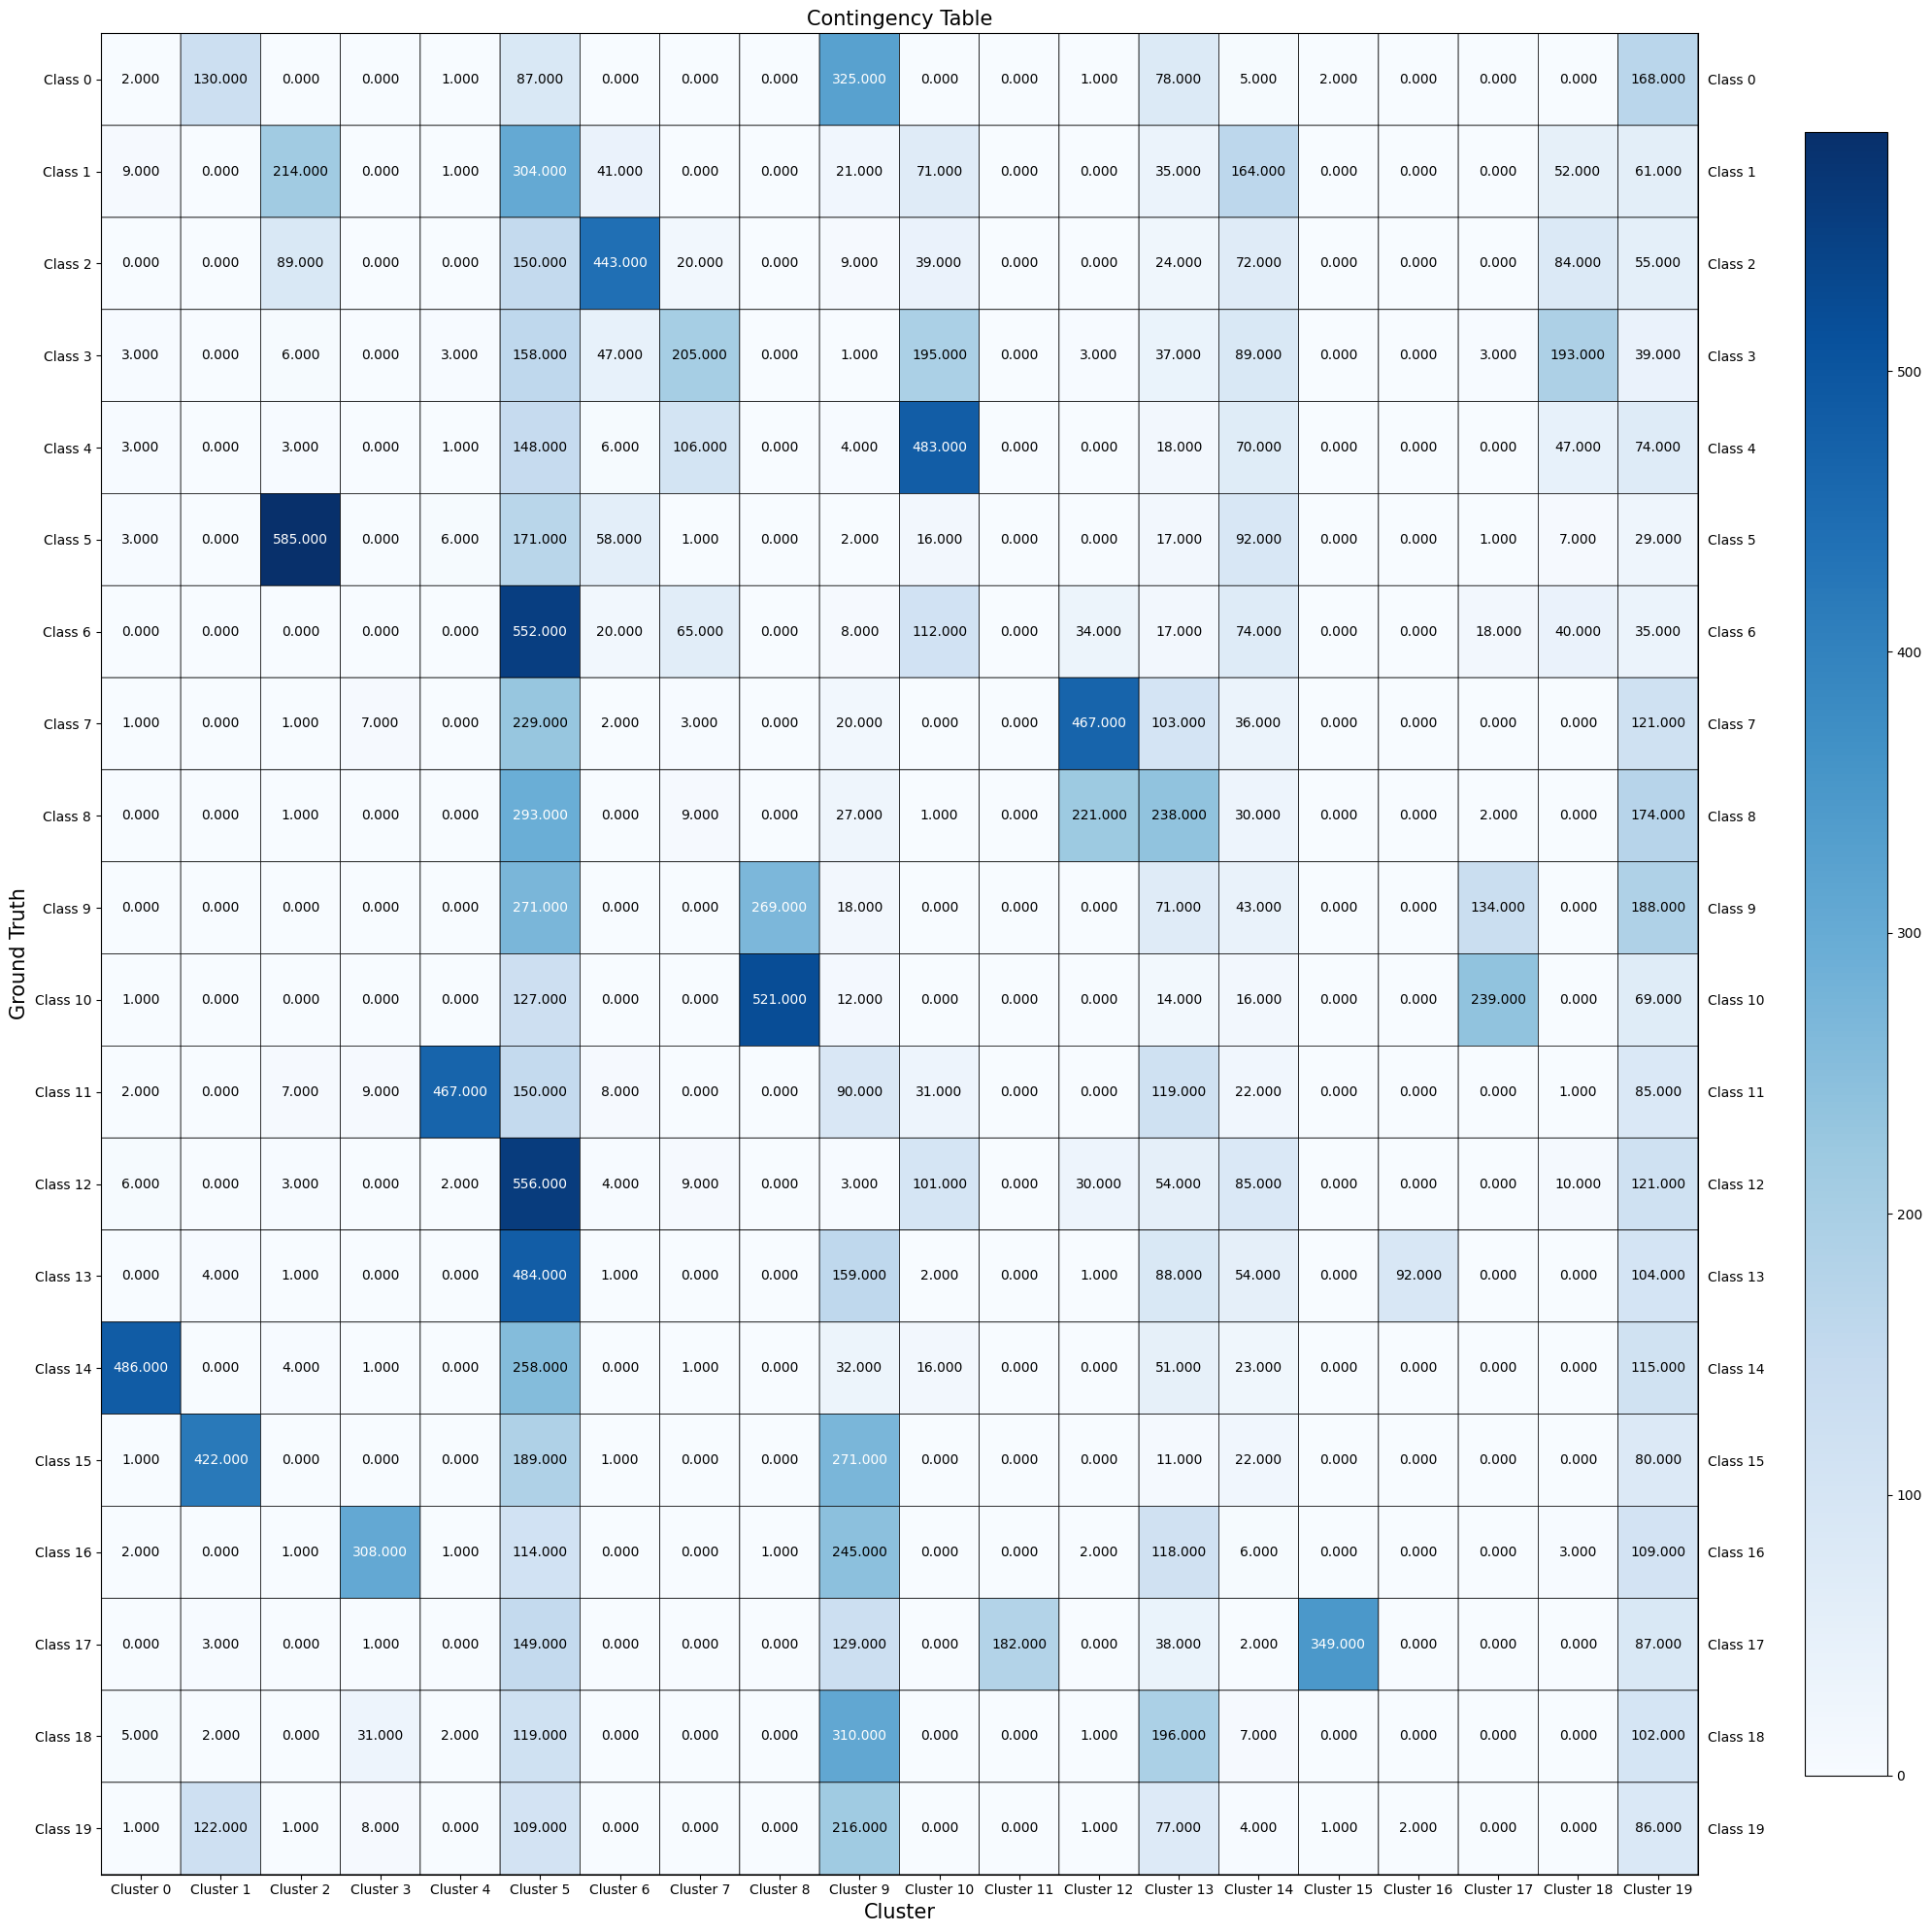

In [18]:
km_svd20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
clusters_svd20 = km_svd20.fit_predict(X_train_tfidf20)

# Ground truth labels
ground_truth = newsgroups_data20.target

mat_svd20 = contingency_matrix(ground_truth, clusters_svd20)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,20)]
ylabels = [f'Class {i}'.format(i) for i in range(0,20)]
plotmat.plot_mat(mat_nmf20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

In [19]:
print("Homogeneity Score:", homogeneity_score(ground_truth, clusters_svd20))
print("Completeness:", completeness_score(ground_truth,clusters_svd20))
print("V-measure:", v_measure_score(ground_truth,clusters_svd20))
print("Adjusted RI", adjusted_rand_score(ground_truth, clusters_svd20))
print("Adjusted MI", adjusted_mutual_info_score(ground_truth, clusters_svd20))

Homogeneity Score: 0.3482673118916205
Completeness: 0.39700467835958114
V-measure: 0.3710423951236527
Adjusted RI 0.12210456974890385
Adjusted MI 0.3688686184350024


### There is a mismatch between cluster labels and class labels. For example, the cluster #3 may correspond to the class #8. As a result, the high-value entries of the 20 × 20 contingency matrix can be scattered around, making it messy to inspect, even if the clustering result is not bad. One can use scipy.optimize.linear_sum_assignment to identify the best-matching cluster-class pairs, and permute the columns of the contingency matrix accordingly. 

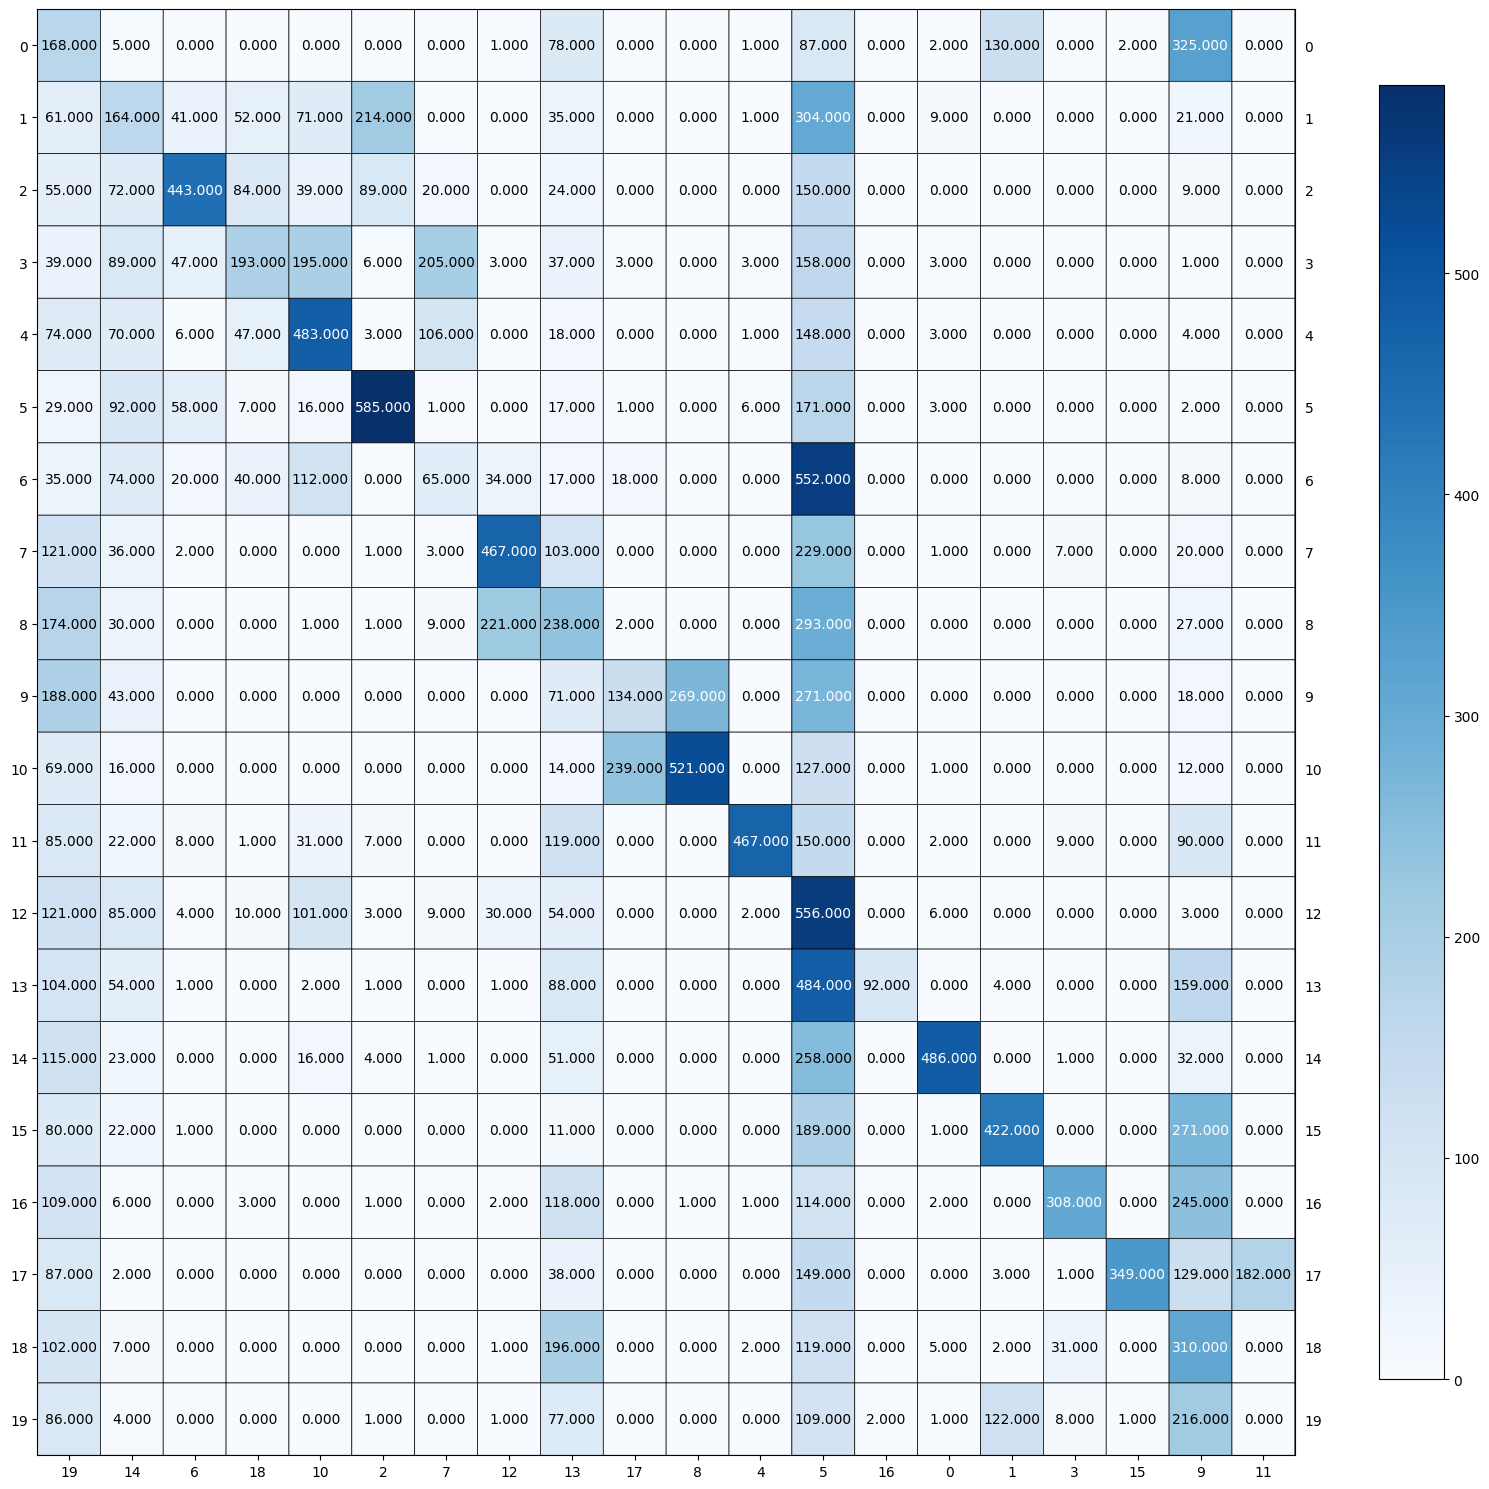

In [22]:
# Contingency Matrix for SVD
cm_svd20 = confusion_matrix(ground_truth, clusters_svd20)
rows, cols = linear_sum_assignment(cm_svd20, maximize = True)
plot_mat(cm_svd20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15))

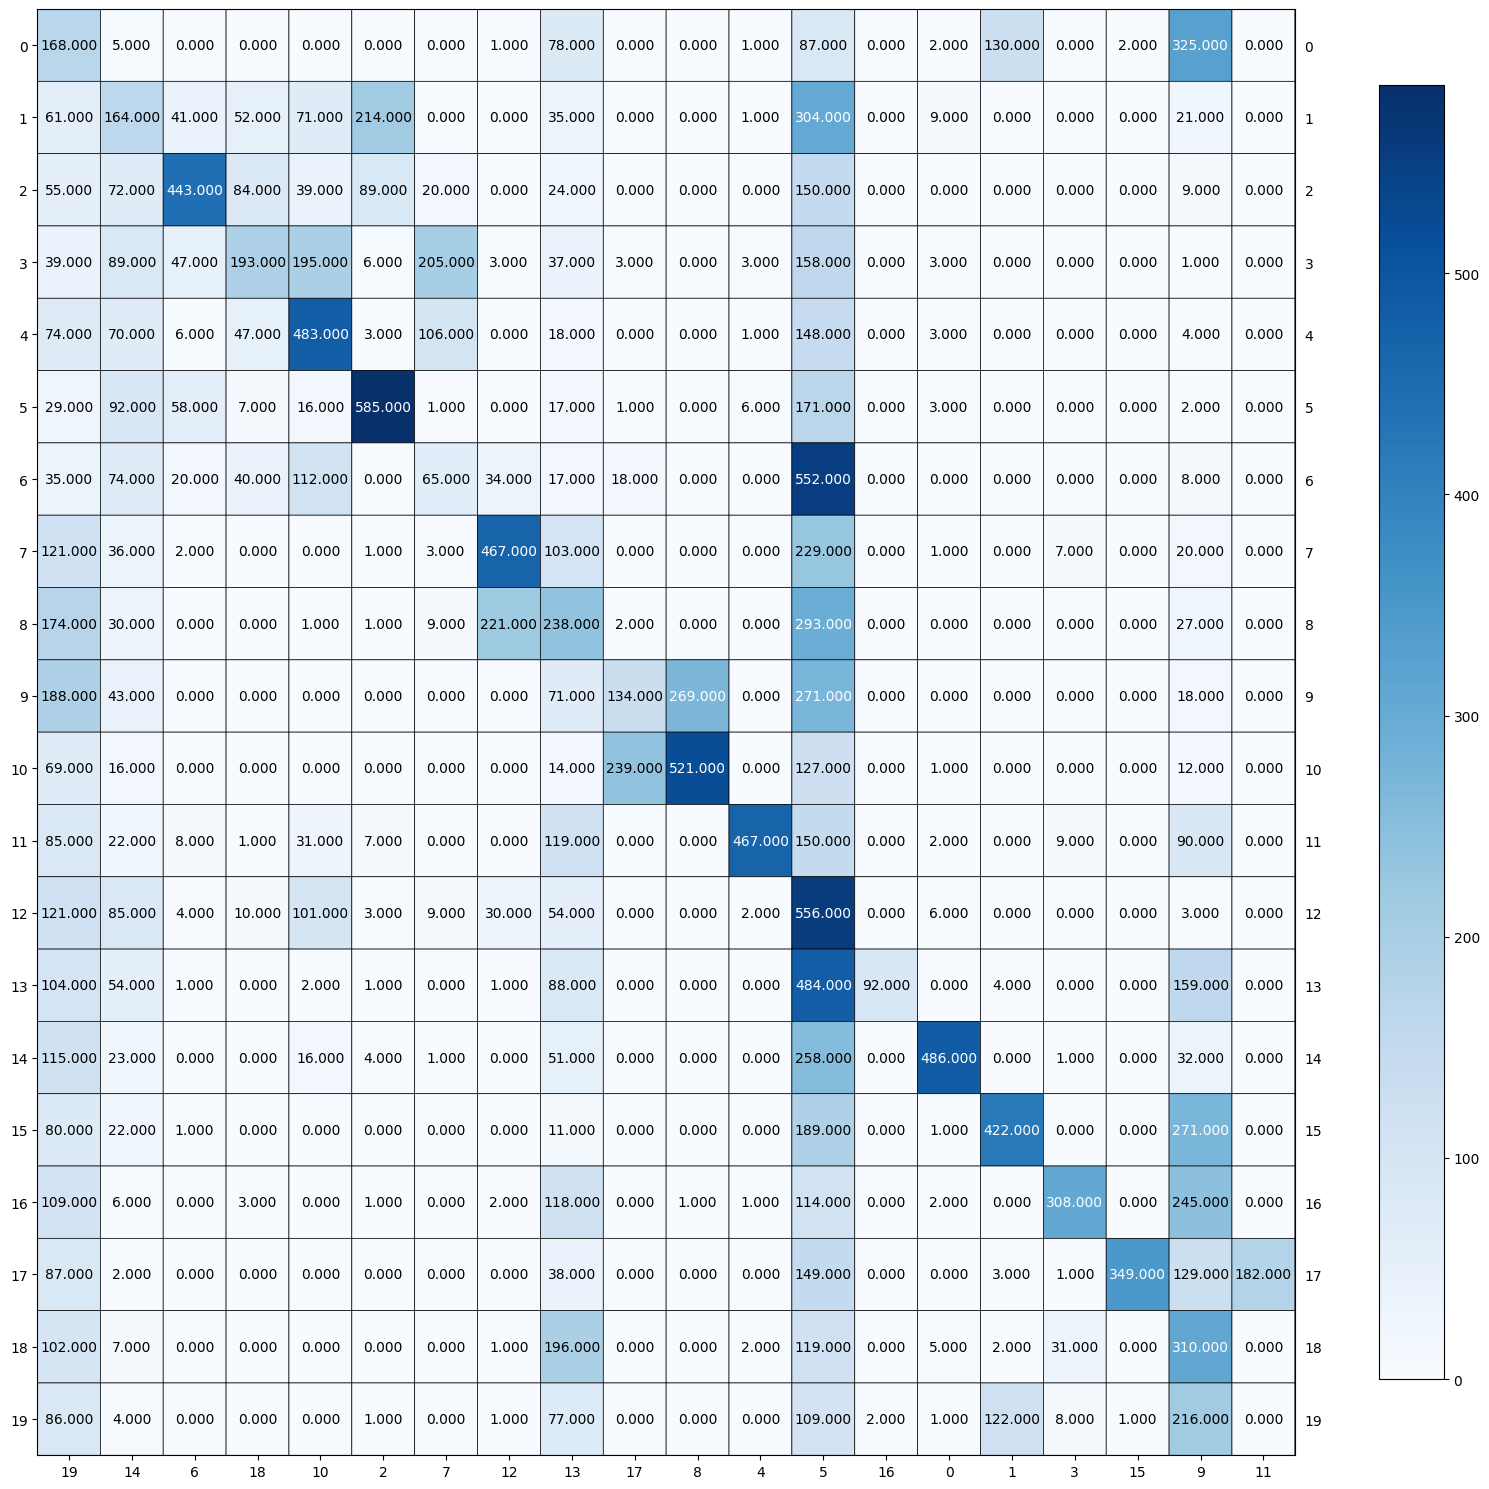

In [23]:
# Contingency Matrix for NMF
cm_nmf20 = confusion_matrix(ground_truth, clusters_nmf20)
rows, cols = linear_sum_assignment(cm_nmf20, maximize = True)
plot_mat(cm_nmf20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15))


### QUESTION 11: Reduce the dimension of your dataset with UMAP. Consider the following settings: n components = [5, 20, 200], metric = ”cosine” vs. ”euclidean”. If ”cosine” metric fails, please look at the FAQ at the end of this spec. Report the permuted contingency matrix and the five clustering evaluation metrics for the different combinations (6 combinations).

In [14]:
def umap_metrics(n_components=5, metric="euclidean", title="UMAP"):
  # Dimensionality Reduction using UMAP
  reducer = umap.UMAP(n_components=n_components, metric=metric)
  embedding = reducer.fit_transform(X_train_tfidf20)
  
  # K-means Clustering (k = 20)
  km_umap20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
  clusters_umap20 = km_umap20.fit_predict(X_train_tfidf20)
  
  # Ground truth labels
  ground_truth20 = newsgroups_data20.target
  
  # Visualizing the matrix using plotmat.py
  cm_umap20 = confusion_matrix(ground_truth, clusters_umap20)
  rows, cols = linear_sum_assignment(cm_umap20, maximize = True)
  plot_mat(cm_umap20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15), title=title)

  # Prints 5 clustering Evaluation Metrics 
  print("Homogeneity Score:", homogeneity_score(ground_truth20, clusters_umap20))
  print("Completeness:", completeness_score(ground_truth20,clusters_umap20))
  print("V-measure:", v_measure_score(ground_truth20,clusters_umap20))
  print("Adjusted RI", adjusted_rand_score(ground_truth20, clusters_umap20))
  print("Adjusted MI", adjusted_mutual_info_score(ground_truth20, clusters_umap20))


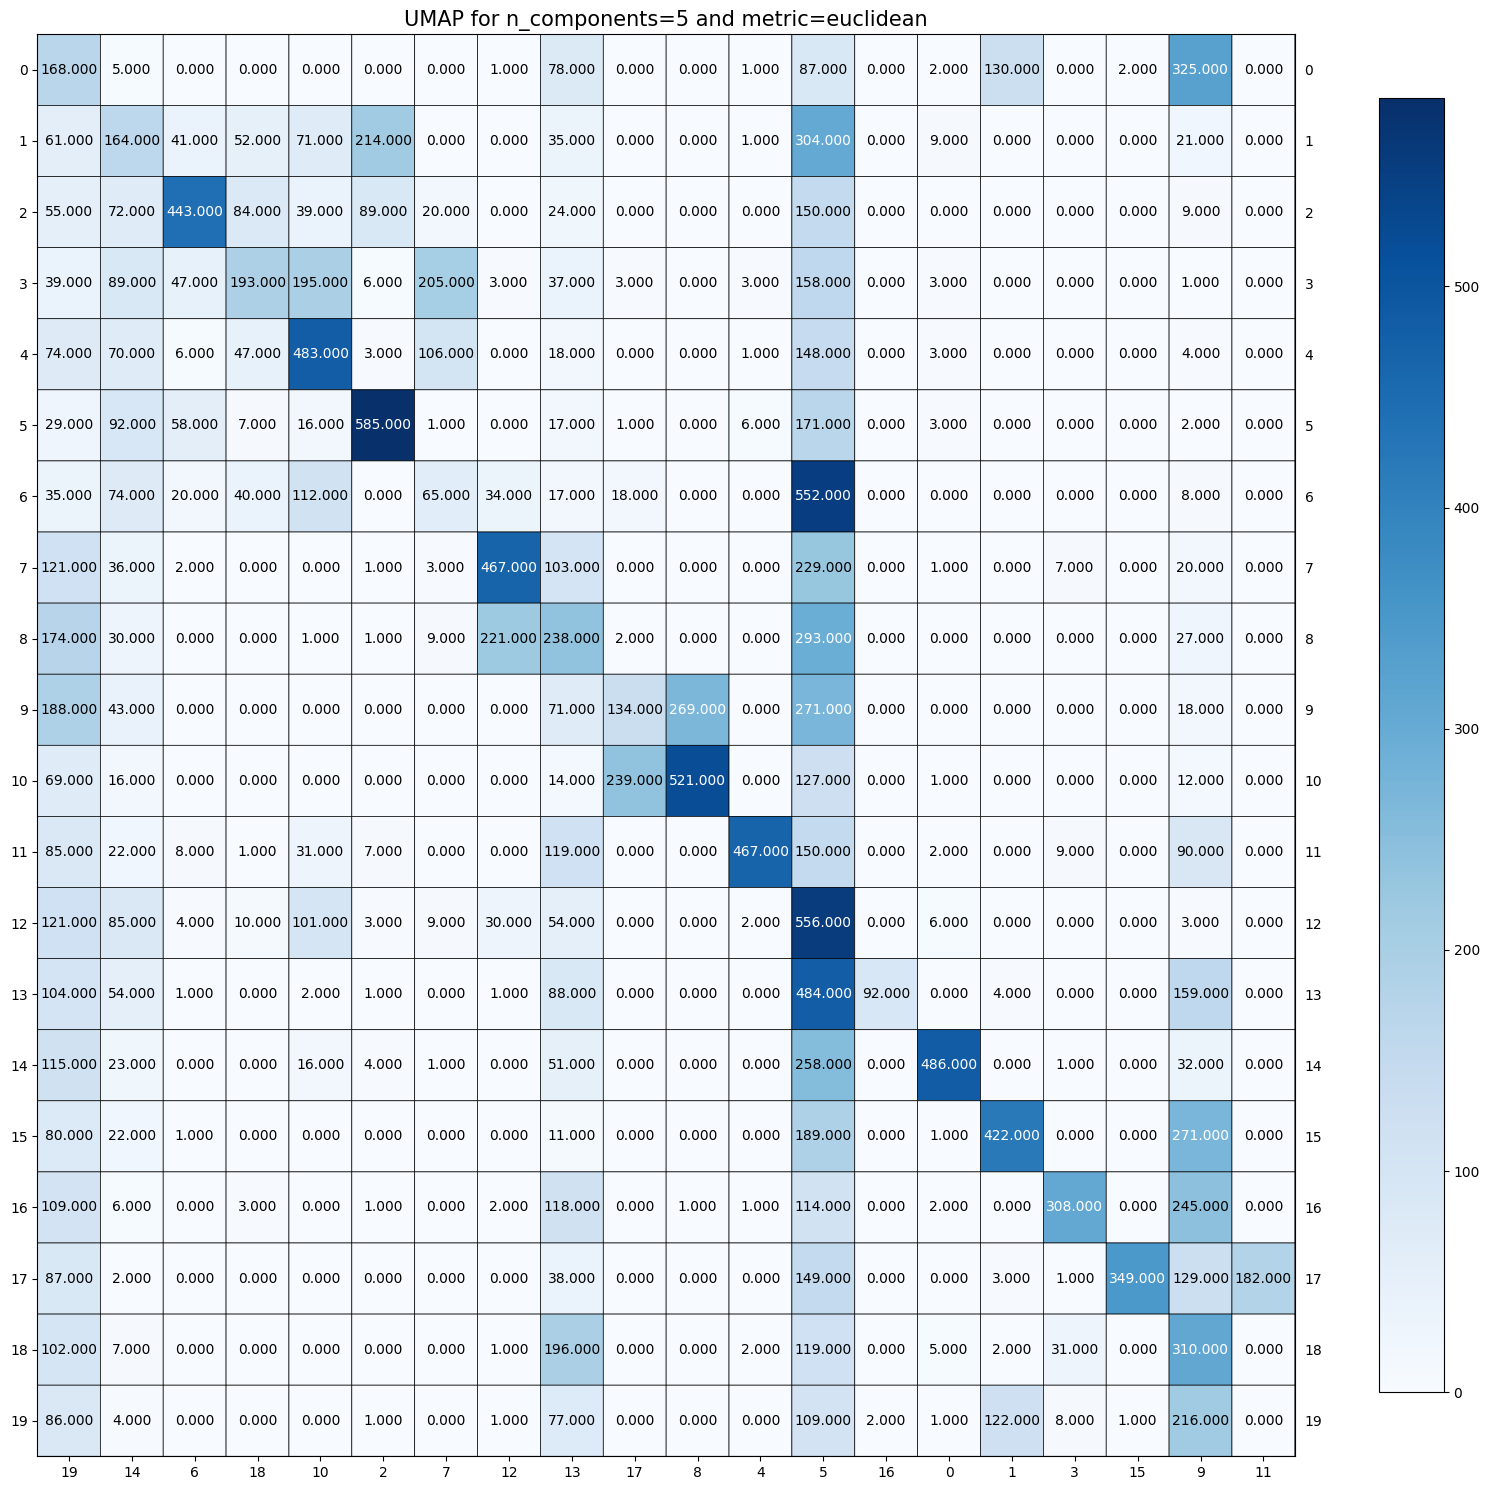

Homogeneity Score: 0.3482673118916205
Completeness: 0.39700467835958114
V-measure: 0.3710423951236527
Adjusted RI 0.12210456974890385
Adjusted MI 0.3688686184350024


In [15]:
umap_metrics(n_components=5, metric="euclidean", title="UMAP for n_components=5 and metric=euclidean")

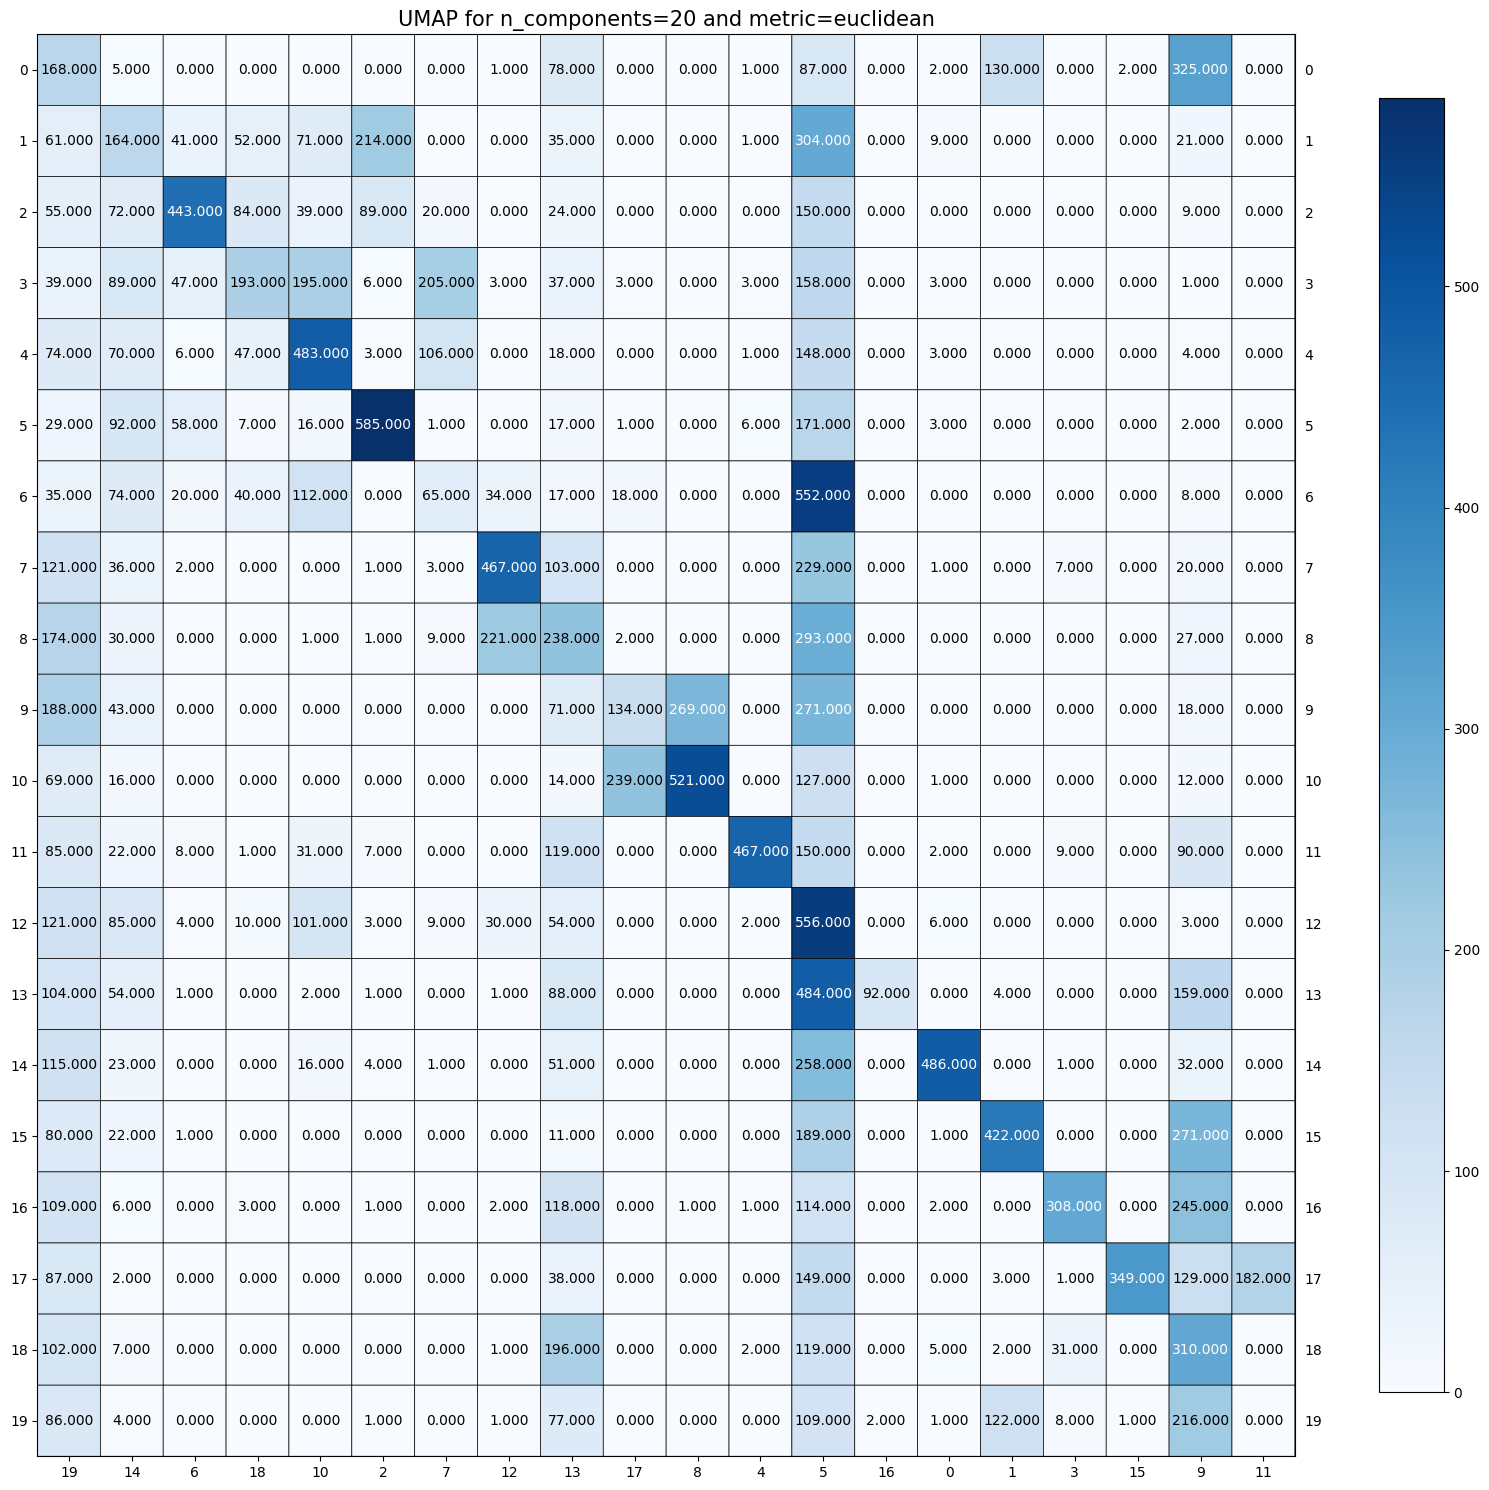

Homogeneity Score: 0.3482673118916205
Completeness: 0.39700467835958114
V-measure: 0.3710423951236527
Adjusted RI 0.12210456974890385
Adjusted MI 0.3688686184350024


In [16]:
umap_metrics(n_components=20, metric="euclidean", title="UMAP for n_components=20 and metric=euclidean")

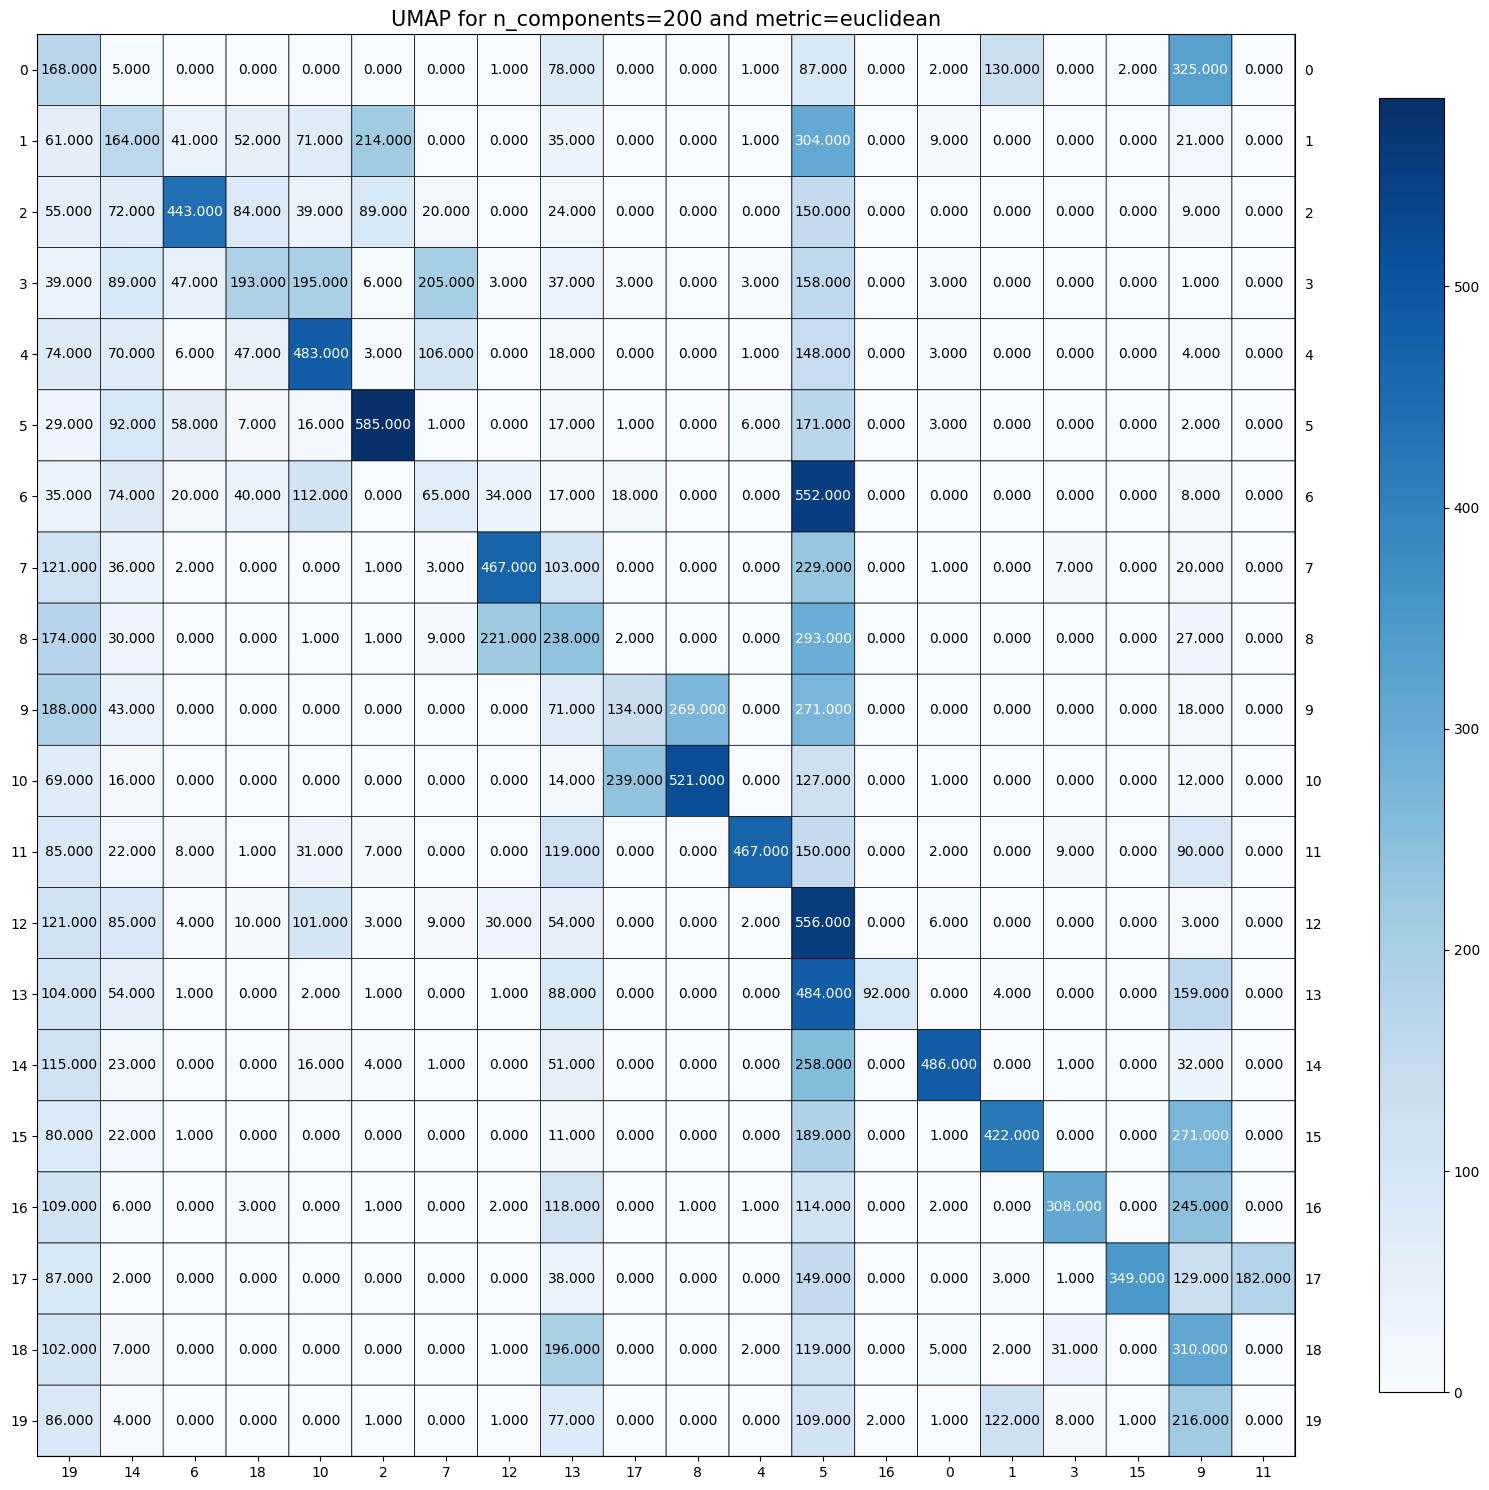

Homogeneity Score: 0.3482673118916205
Completeness: 0.39700467835958114
V-measure: 0.3710423951236527
Adjusted RI 0.12210456974890385
Adjusted MI 0.3688686184350024


In [17]:
umap_metrics(n_components=200, metric="euclidean", title="UMAP for n_components=200 and metric=euclidean")

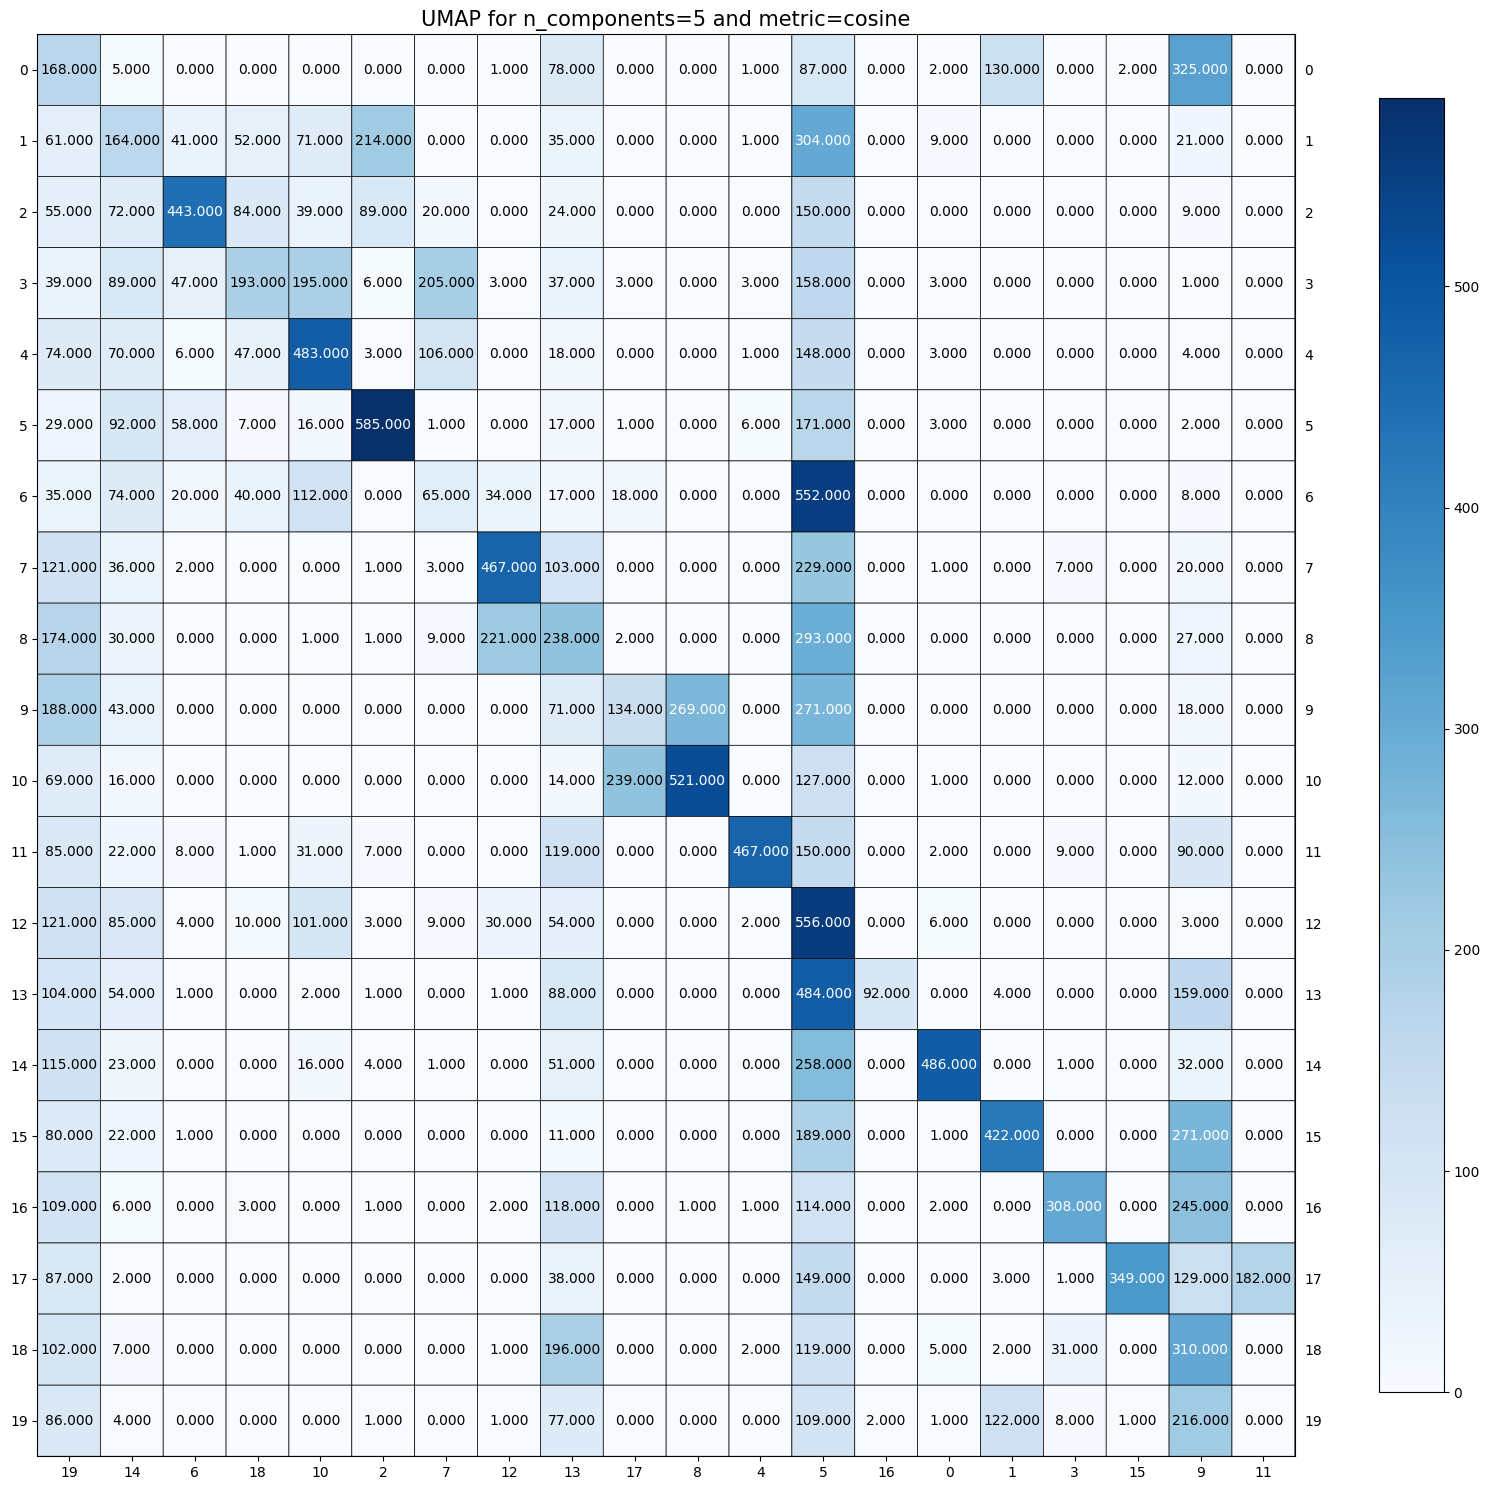

Homogeneity Score: 0.3482673118916205
Completeness: 0.39700467835958114
V-measure: 0.3710423951236527
Adjusted RI 0.12210456974890385
Adjusted MI 0.3688686184350024


In [18]:
umap_metrics(n_components=5, metric="cosine", title="UMAP for n_components=5 and metric=cosine")

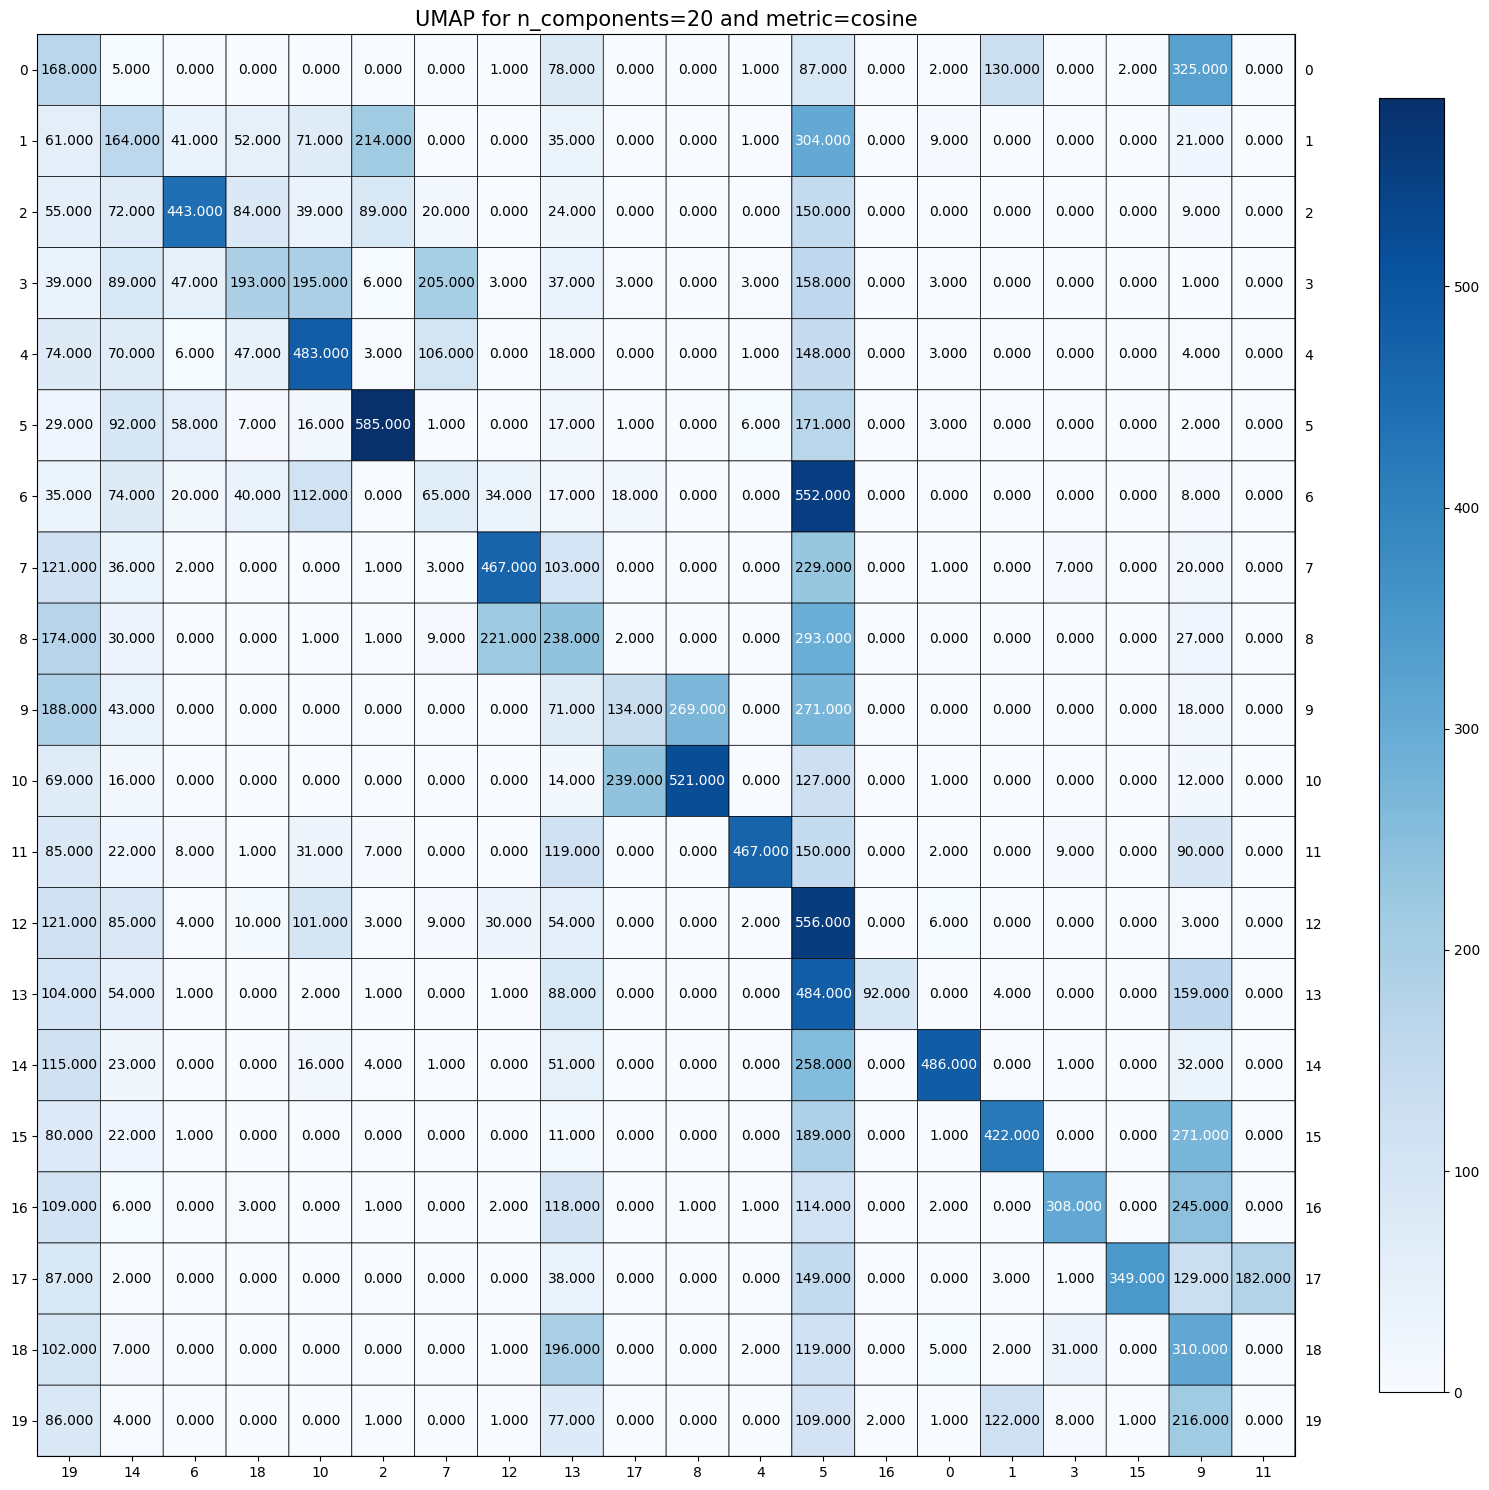

Homogeneity Score: 0.3482673118916205
Completeness: 0.39700467835958114
V-measure: 0.3710423951236527
Adjusted RI 0.12210456974890385
Adjusted MI 0.3688686184350024


In [19]:
umap_metrics(n_components=20, metric="cosine", title="UMAP for n_components=20 and metric=cosine")

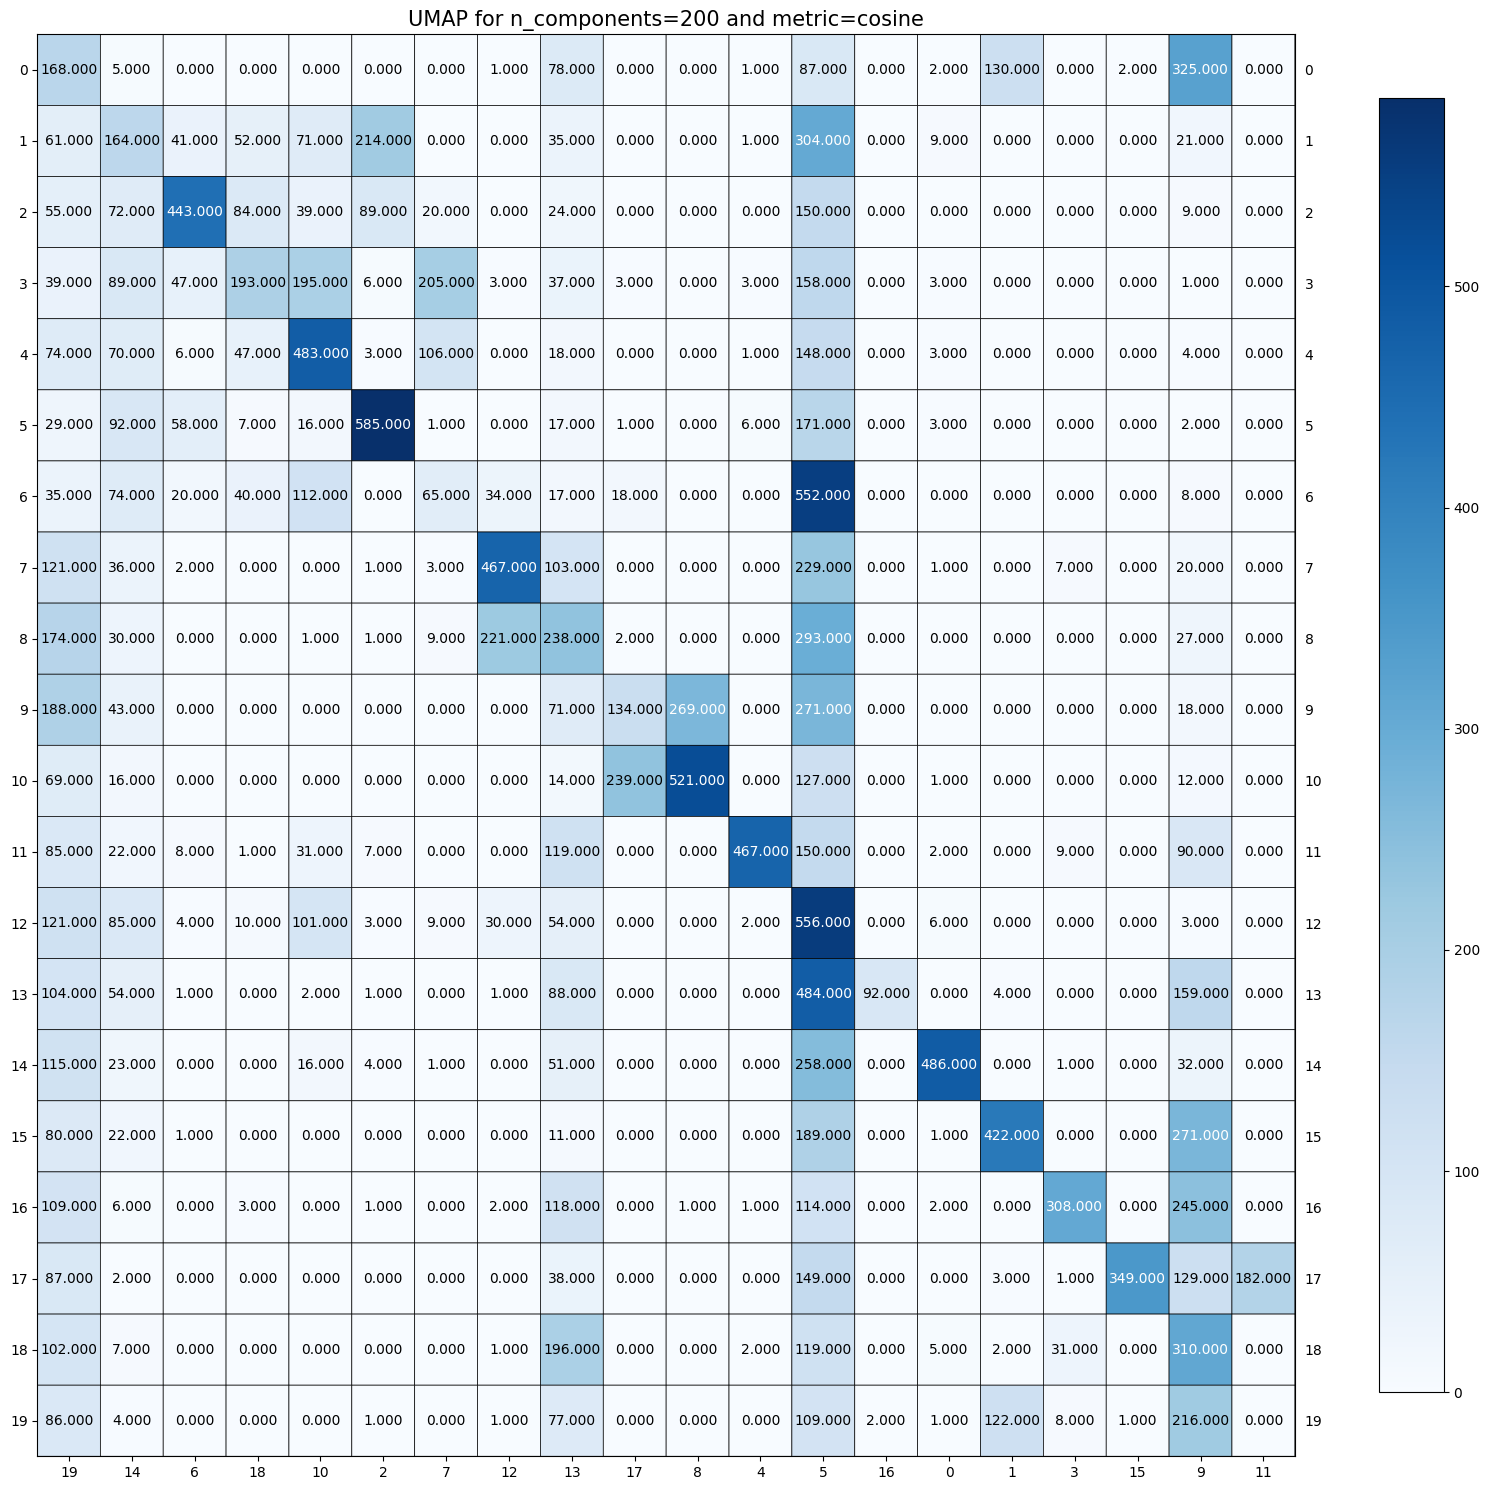

Homogeneity Score: 0.3482673118916205
Completeness: 0.39700467835958114
V-measure: 0.3710423951236527
Adjusted RI 0.12210456974890385
Adjusted MI 0.3688686184350024


In [21]:
umap_metrics(n_components=200, metric="cosine", title="UMAP for n_components=200 and metric=cosine")

# Part 2 - Deep Learning and Clustering of Image Data

## Question 19

### 19.1 In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?